/home/antsa/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


---- TF-IDF done ----


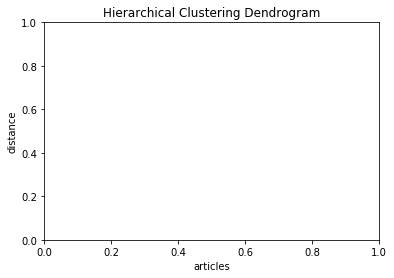

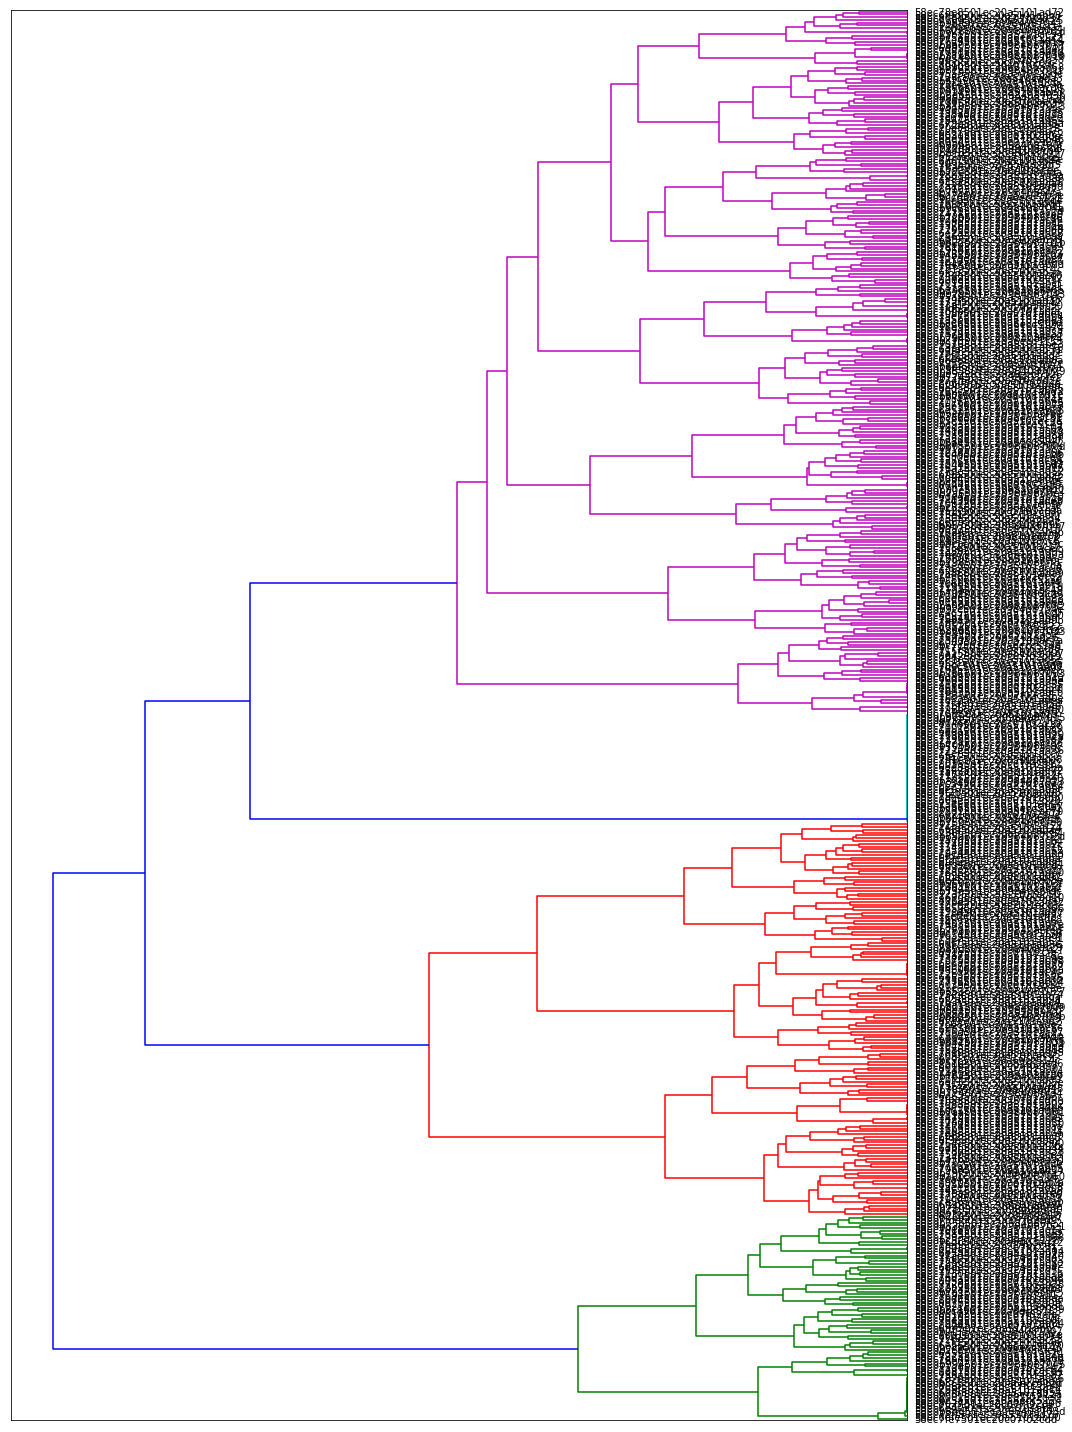

In [1]:
#!/usr/bin/python
################################################################################
#Author: Antsa Raharimanantsoa
#Description: Classification using clustering algorithm
#Creation_date: March 2017
################################################################################

import nltk
from mongoengine import *
from document import *
from lib import *
from algo_clustering import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster
from operator import itemgetter
from itertools import groupby
import logging
from datetime import datetime
import time

log_name = datetime.now().strftime("%Y%m%d_%H%M")
logging.basicConfig(filename='log/clusters/' + log_name + '.log',
                    level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d-%m-%Y %I:%M:%S %p')

stopwords = nltk.corpus.stopwords.words('french')
stopwords += nltk.corpus.stopwords.words('english')

"""Retrieve all contents for the clustering"""
content = get_content_article()
logging.info("Retrieve all articles for the classification")

"""tf-idf representation"""
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,stop_words=stopwords,
                                    use_idf=True,ngram_range=(1,3)
                                    ,tokenizer=tokenize_only)
tfidf_matrix = tfidf_vectorizer.fit_transform(content.values())

print('---- TF-IDF done ----')
logging.info("TF-IDF done, clustering ongoing ...")

"""Here is the call of the method of classification, defined in algo_clustering.py """
dist = 1 - cosine_similarity(tfidf_matrix)
#numbers = meanshift(tfidf_matrix)
#numbers=[110,115,120,125,130,135]
#kmeans(tfidf_matrix,numbers)
hierarchical(dist,content.keys())
